In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set up your Google Drive credentials to access the data

# Step 1: Load the data from Google Drive

def load_data_from_drive(folder_path):
    data = []
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        image_path = os.path.join(folder_path, file_name)
        image = load_img(image_path, target_size=(256, 256))
        image = img_to_array(image)
        data.append(image)
    return np.array(data)

real_depth_folder_path = '/content/gdrive/MyDrive/Saad/Data/Real_Depth/'
simulated_depth_folder_path = '/content/gdrive/MyDrive/Saad/Data/Virtual/livingroom1-depth-clean/'

real_depth_data = load_data_from_drive(real_depth_folder_path)
simulated_depth_data = load_data_from_drive(simulated_depth_folder_path)




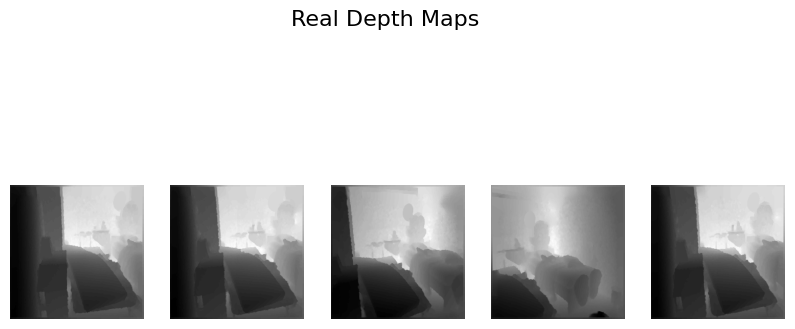

<ipython-input-3-c8720e8e29c7>:9: RuntimeWarning: invalid value encountered in true_divide
  image = (image - np.min(image)) / (np.max(image) - np.min(image))


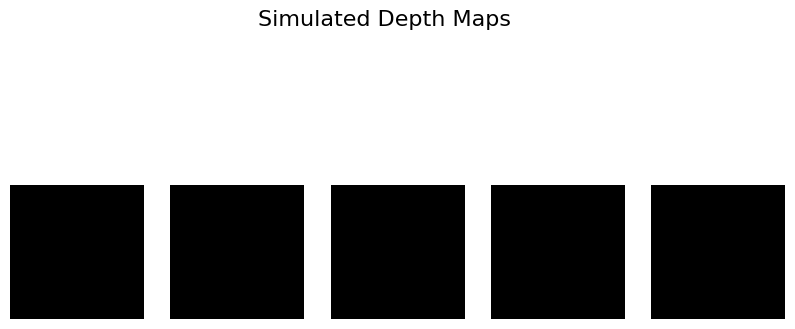

In [3]:
# Step 2: Display a sample of images from both folders

def display_images_with_folder_name(images, folder_name, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    fig.suptitle(folder_name, fontsize=16)
    for i in range(num_images):
        # Normalize the image to [0, 1] range
        image = images[i]
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Display a sample of real depth maps with folder name
num_real_depth_images = 5
display_images_with_folder_name(real_depth_data, 'Real Depth Maps', num_real_depth_images)

# Display a sample of simulated depth maps with folder name
num_simulated_depth_images = 5
display_images_with_folder_name(simulated_depth_data, 'Simulated Depth Maps', num_simulated_depth_images)


In [4]:
# Step 3: Normalize the images

real_depth_data = real_depth_data / 255.0
simulated_depth_data = simulated_depth_data / 255.0

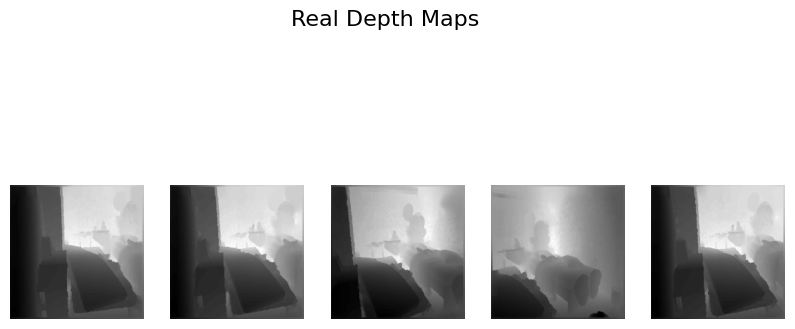

<ipython-input-3-c8720e8e29c7>:9: RuntimeWarning: invalid value encountered in true_divide
  image = (image - np.min(image)) / (np.max(image) - np.min(image))


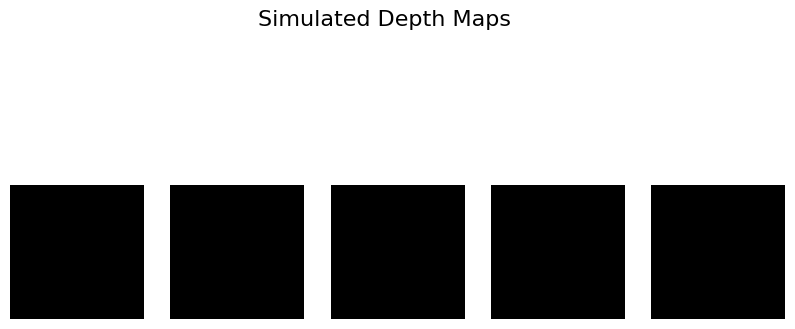

In [5]:
# Display a sample of real depth maps with folder name
num_real_depth_images = 5
display_images_with_folder_name(real_depth_data, 'Real Depth Maps', num_real_depth_images)

# Display a sample of simulated depth maps with folder name
num_simulated_depth_images = 5
display_images_with_folder_name(simulated_depth_data, 'Simulated Depth Maps', num_simulated_depth_images)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os
import cv2
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=6):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  1,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 1, 7, 1, 0),
                nn.Sigmoid()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [9]:
nc=1
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1),
            # state size. 1 x 14 x 14
            nn.Flatten(),
            nn.Linear(40, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [11]:
class RealDataset(Dataset):
  def __init__(self, path):
    self.path = path
    self.filename = []
    self.cummulative_sizes = []
    self.folders = ["/content/gdrive/MyDrive/Saad/Data/"]
    self.folder_dir = path + ""
    for images in os.listdir(self.folder_dir):
    # check if the image ends with png
      if (images.endswith(".png")):
        self.filename.append(images)
    self.cummulative_sizes.append(len(self.filename))

  def __len__(self):
    return len(self.filename)
  def __getitem__(self, idx):
    for i in range(len(self.cummulative_sizes)):
      if self.cummulative_sizes[i] > idx:
        idx_folder = i
        break
    #img = cv2.imread(self.path  + self.filename[idx])
    #img = img[::8, ::8, 1]
    img = Image.open(self.path  + self.filename[idx]).convert('F')
    img = np.asarray(img)
    return torch.from_numpy(np.float32(img[::2, ::2])/260).unsqueeze(0)

In [12]:
class FakeDataset(Dataset):
  def __init__(self, path):
    self.path = path
    self.filename = []
    i = 0
    for images in os.listdir(self.path):
      i = i+1
    # check if the image ends with png
      if (images.endswith(".png")):
        self.filename.append(images)
      if(i > 1000):
        break
  def __len__(self):
    return len(self.filename)
  def __getitem__(self, idx):
    #img = cv2.imread(self.path + self.filename[idx])
    #img = img[::8, ::8, 1]
    img = Image.open(self.path + self.filename[idx]).convert('F')
    img = np.asarray(img)
    return torch.from_numpy(np.float32(img[::2, ::2])/23).unsqueeze(0)

In [13]:
data_real = RealDataset('/content/gdrive/MyDrive/Saad/Data/ST_R/')
data_fake = FakeDataset('/content/gdrive/MyDrive/Saad/Data/ST_V/')
real_train, real_val = random_split(data_real, [0.7, 0.3], generator=torch.Generator().manual_seed(42))
fake_train, fake_val = random_split(data_fake, [0.7, 0.3], generator=torch.Generator().manual_seed(42))
real_loader = DataLoader(real_train, batch_size = 8, shuffle = True)
fake_loader = DataLoader(fake_train, batch_size = 8, shuffle = True)
epochs = 10
Gen_R = Generator()
Gen_F = Generator()
Dis_R = Discriminator()
Dis_F = Discriminator()

opt_gen = optim.Adam(list(Gen_R.parameters()) + list(Gen_F.parameters()), lr = 0.0001)
opt_dis = optim.Adam(list(Dis_R.parameters()) + list(Dis_F.parameters()), lr = 0.0001)
L1 = nn.L1Loss()
LAMBDA = 10

In [ ]:
loss_dis = []
loss_gen = []
for j in range(5):
  loss_d = 0
  loss_g = 0
  for real in tqdm(real_loader):
    opt_gen.zero_grad()
    opt_dis.zero_grad()
    fake = next(iter(fake_loader))

    generated_real = Gen_R(fake)
    cycled_fake = Gen_F(generated_real)

    generated_fake = Gen_F(real)
    cycled_real = Gen_F(generated_fake)

    disc_real = Dis_R(real)
    disc_fake = Dis_F(fake)

    disc_gen_real = Dis_R(generated_real.detach())
    disc_gen_fake = Dis_F(generated_fake.detach())

    gen_R_loss = LSGAN_G(disc_gen_real)
    gen_F_loss = LSGAN_G(disc_gen_fake)

    total_cycle_loss = L1(real, cycled_real) + L1(fake, cycled_fake)

    total_gen_loss = gen_R_loss + gen_F_loss + LAMBDA * total_cycle_loss + LAMBDA * 0.5 * L1(real, same_real)

    dis_R_loss = LSGAN_D(disc_real, disc_gen_real)
    dis_F_loss = LSGAN_D(disc_fake, disc_gen_fake)

    dis_loss = (dis_R_loss + dis_F_loss)/2

    dis_loss.backward(retain_graph = True)
    total_gen_loss.backward()

    opt_gen.step()
    opt_dis.step()

    loss_d = loss_d + dis_loss.item()
    loss_g = loss_g + total_gen_loss.item()

  loss_dis.append(loss_d/len(real_loader))
  loss_gen.append(loss_g/len(real_loader))
  print('Generator Loss: ' + str(loss_g/len(real_loader)))
  print('Discriminator Loss: ' + str(loss_d/len(real_loader)))

print(loss_dis)
print(loss_gen)

In [ ]:
generated_real = Gen_R(fake)
cycled_fake = Gen_F(generated_real)

generated_fake = Gen_F(real)
cycled_real = Gen_F(generated_fake)

same_real = Gen_R(real)
same_fake = Gen_F(fake)
L1(real, same_real)

tensor(0.0433, grad_fn=<MeanBackward0>)

In [ ]:
gen_R_loss

tensor(0.1077, grad_fn=<MeanBackward0>)

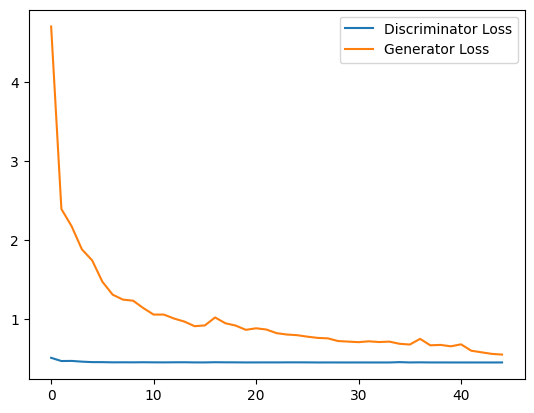

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_dis, label = 'Discriminator Loss')
plt.plot(loss_gen, label = 'Generator Loss')
plt.legend()

In [ ]:
torch.save(Gen_R.state_dict(), '/content/drive/MyDrive/generator_f2r_weights.pth')
torch.save(Dis_R.state_dict(), '/content/drive/MyDrive/discriminator_f2r_weight.pth')
torch.save(Gen_F.state_dict(), '/content/drive/MyDrive/generator_r2f_weights.pth')
torch.save(Dis_F.state_dict(), '/content/drive/MyDrive/discriminator_r2f_weight.pth')

In [ ]:
print(loss_gen)
print(loss_dis)

[0.5735511132856694, 0.5536044643419545, 0.5447558771546294]
[0.4446294220482431, 0.4444296385456876, 0.4449047591628098]


In [ ]:
loss_gen = [4.707152384083446, 2.39158801029, 2.1721260242345855, 1.8796694293254759, 1.740287018985283, 1.4688671972693466, 1.3049279087927284, 1.2421574069232475, 1.2282891825931828, 1.1341959935862844, 1.052176586738447, 1.0520898699760437, 1.001541084632641, 0.9633743305031847, 0.904753904517104, 0.9147159769767668, 1.015636906391237, 0.9421867750039915, 0.9127316271386495, 0.8587228873880898, 0.878132956783946, 0.8626252965229314, 0.8164675889945612, 0.79899426785911, 0.7908024693407664, 0.7718879689530629, 0.7563781207654534, 0.7503441812061682, 0.7164885169122277, 0.7090980599566203, 0.7023355895426215, 0.7130226740022985, 0.7037001121334914, 0.7092590026739167, 0.6814754031053404, 0.6720566735035036, 0.7438508046836387, 0.6623793854946043, 0.6673515497184381, 0.6494277504886069, 0.6744949199804445, 0.593494349863471, 0.5735511132856694, 0.5536044643419545, 0.5447558771546294]
loss_dis = [0.5035025190289427, 0.46274810558, 0.46428209034408013, 0.45495767891407013, 0.44907484984979396, 0.4487064538932428, 0.44618306581566974, 0.44671615158639305, 0.44616896095799236, 0.44735749029531713, 0.44611457898849394, 0.44565927291788704, 0.4467567794206666, 0.4470544017669631, 0.445233298147597, 0.445195841716557, 0.44761893734699343, 0.4462218022928005, 0.44597930733750507, 0.44484856870116257, 0.4451022958610116, 0.44541253113165136, 0.44518165653798636, 0.44594910995262427, 0.44604728607142846, 0.44565061861422006, 0.44446008743309395, 0.4447532158072402, 0.444661887317169, 0.44451095091133586, 0.44468745225813333, 0.4445833927247582, 0.44458146647709174, 0.44448857082099447, 0.448808160860364, 0.4448417461499935, 0.4461570803712054, 0.4447218263294639, 0.44482261523967837, 0.4446172561587357, 0.4445879670178018, 0.44456423964442277, 0.4446294220482431, 0.4444296385456876, 0.4449047591628098]

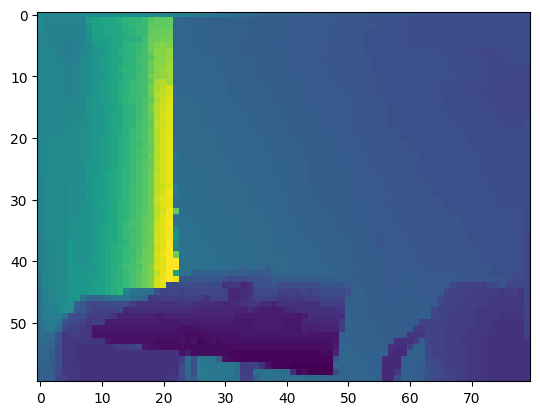

In [ ]:
realV_loader = DataLoader(real_val, batch_size = 1, shuffle = True)
realV = next(iter(realV_loader))
reconstruct = Gen_F(realV)
plt.imshow(realV.detach()[0,0])

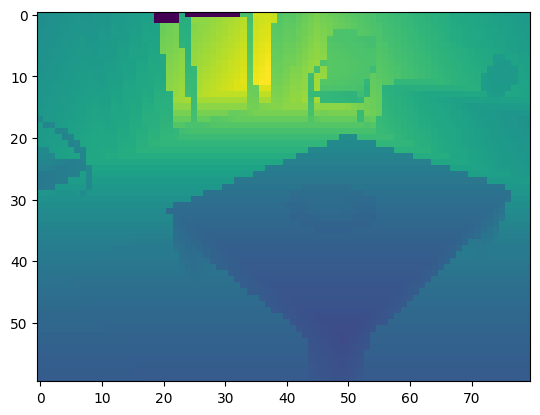

In [ ]:
fakeV_loader = DataLoader(fake_val, batch_size = 1, shuffle = True)
fakeV = next(iter(fakeV_loader))
reconstruct = Gen_R(fakeV)
plt.imshow(fakeV.detach()[0,0])